---
title: cheg325 homework7 SIS 11.5-8
author: kyle wodehouse
date: today
format:
    html:
        self-contained: true
---

first let's get our data into the notebook and see what it looks like

In [1]:
import pandas as pd
from scipy.constants import R
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

T = 273.15 + 25.0
df = pd.read_csv('data.txt', sep=' ')
df.head(3)

,Cs,pi
0,0.901,58.7
1,1.841,121.2
2,4.070,271.3


lets quickly visualize it to get an ideal of how big we should expect $B_2$ to be. if it looks pretty linear we'll expect $B_2$ to be pretty small

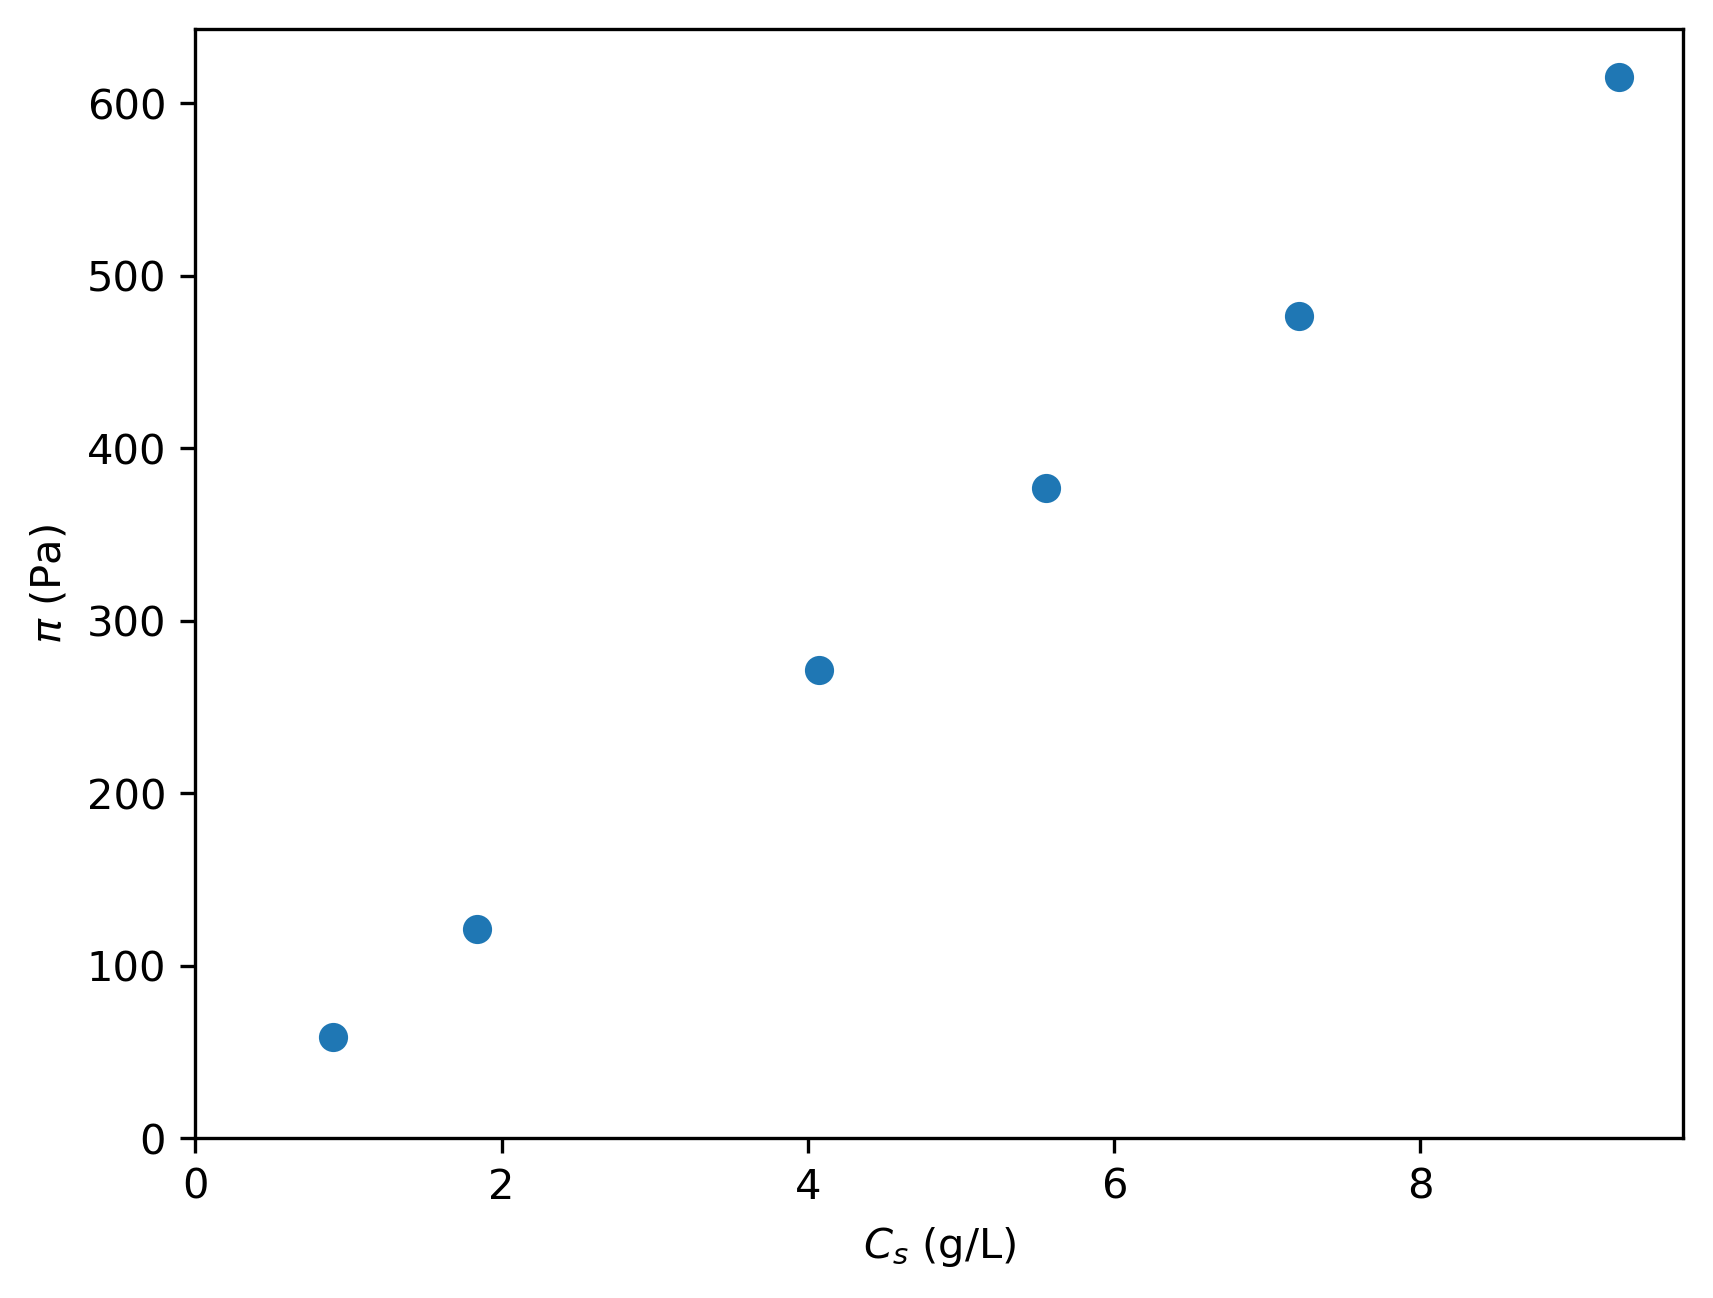

In [2]:
x = np.array(df['Cs'])
y = np.array(df['pi'])

fig, ax = plt.subplots(dpi=300)
ax.scatter(x, y)
ax.set(xlim=0, ylim=0, xlabel='$C_s$ (g/L)', ylabel='$\pi$ (Pa)');

the equation we want to fit our experimental data to is this

$$
\frac{\pi}{RT} = \frac{C_{s}}{M} \biggl[ 1 + B_2 \left( \frac{C_{s}}{M} \right) \biggr]
$$

and we can actually just do this with straight up curve fitting if we rearrange slightly

$$
\pi = RT \frac{C_{s}}{M} \biggl[ 1 + B_2 \left( \frac{C_{s}}{M} \right) \biggr]
$$


let's convert all our units to SI units so they're easy to discern at the end

$$
\frac{\text{g}}{\text{L}} \times \frac{1 \text{kg}}{1000 \text{g}} \times \frac{1000\,\text{L}}{1\,\text{m}^3} = \frac{1\,\text{kg}}{1 \,\text{m}^3}
$$

now we can just simply curve fit and know our molecular mass will be in kg/mol. and in order to figure out the units on the fitted $B_2$ we can multiply out the $\pi$ equation

$$
\pi = RT \frac{C_{s}}{M} + RT B_2 \left( \frac{C_{s}}{M} \right)^2
$$

we see

$$
\text{Pa} = \left( \frac{\text{J}}{\text{mol} \cdot \text{K}} \right) (\text{K}) (B_2) \left( \frac{\text{kg}/\text{m}^3}{\text{kg}/\text{mol}} \right)^2 = \left( \frac{\text{J}}{\text{mol}} \right) (B_2) \left( \frac{\text{mol}}{\text{m}^3} \right)^2
$$

$$
\frac{\text{J}}{\text{m}^3} = \text{J} \cdot \text{mol} \cdot B_2 \cdot \text{m}^{-6} \hspace{2em} \longrightarrow \hspace{2em} B_2 = \frac{\text{m}^3}{\text{mol}}
$$

In [3]:
def pi(Cs, M, B2):
    return R * T * (Cs/M) * (1 + B2 * (Cs/M))

(m,b2),_ = curve_fit(pi, df['Cs'], df['pi'])
print(f'molecular weight: {1000*m:.1f} g/mol')
print(f'B2: {b2:.4f} m^3/mol')

molecular weight: 36655.0 g/mol
B2: -0.0860 m^3/mol


and visualize our fit

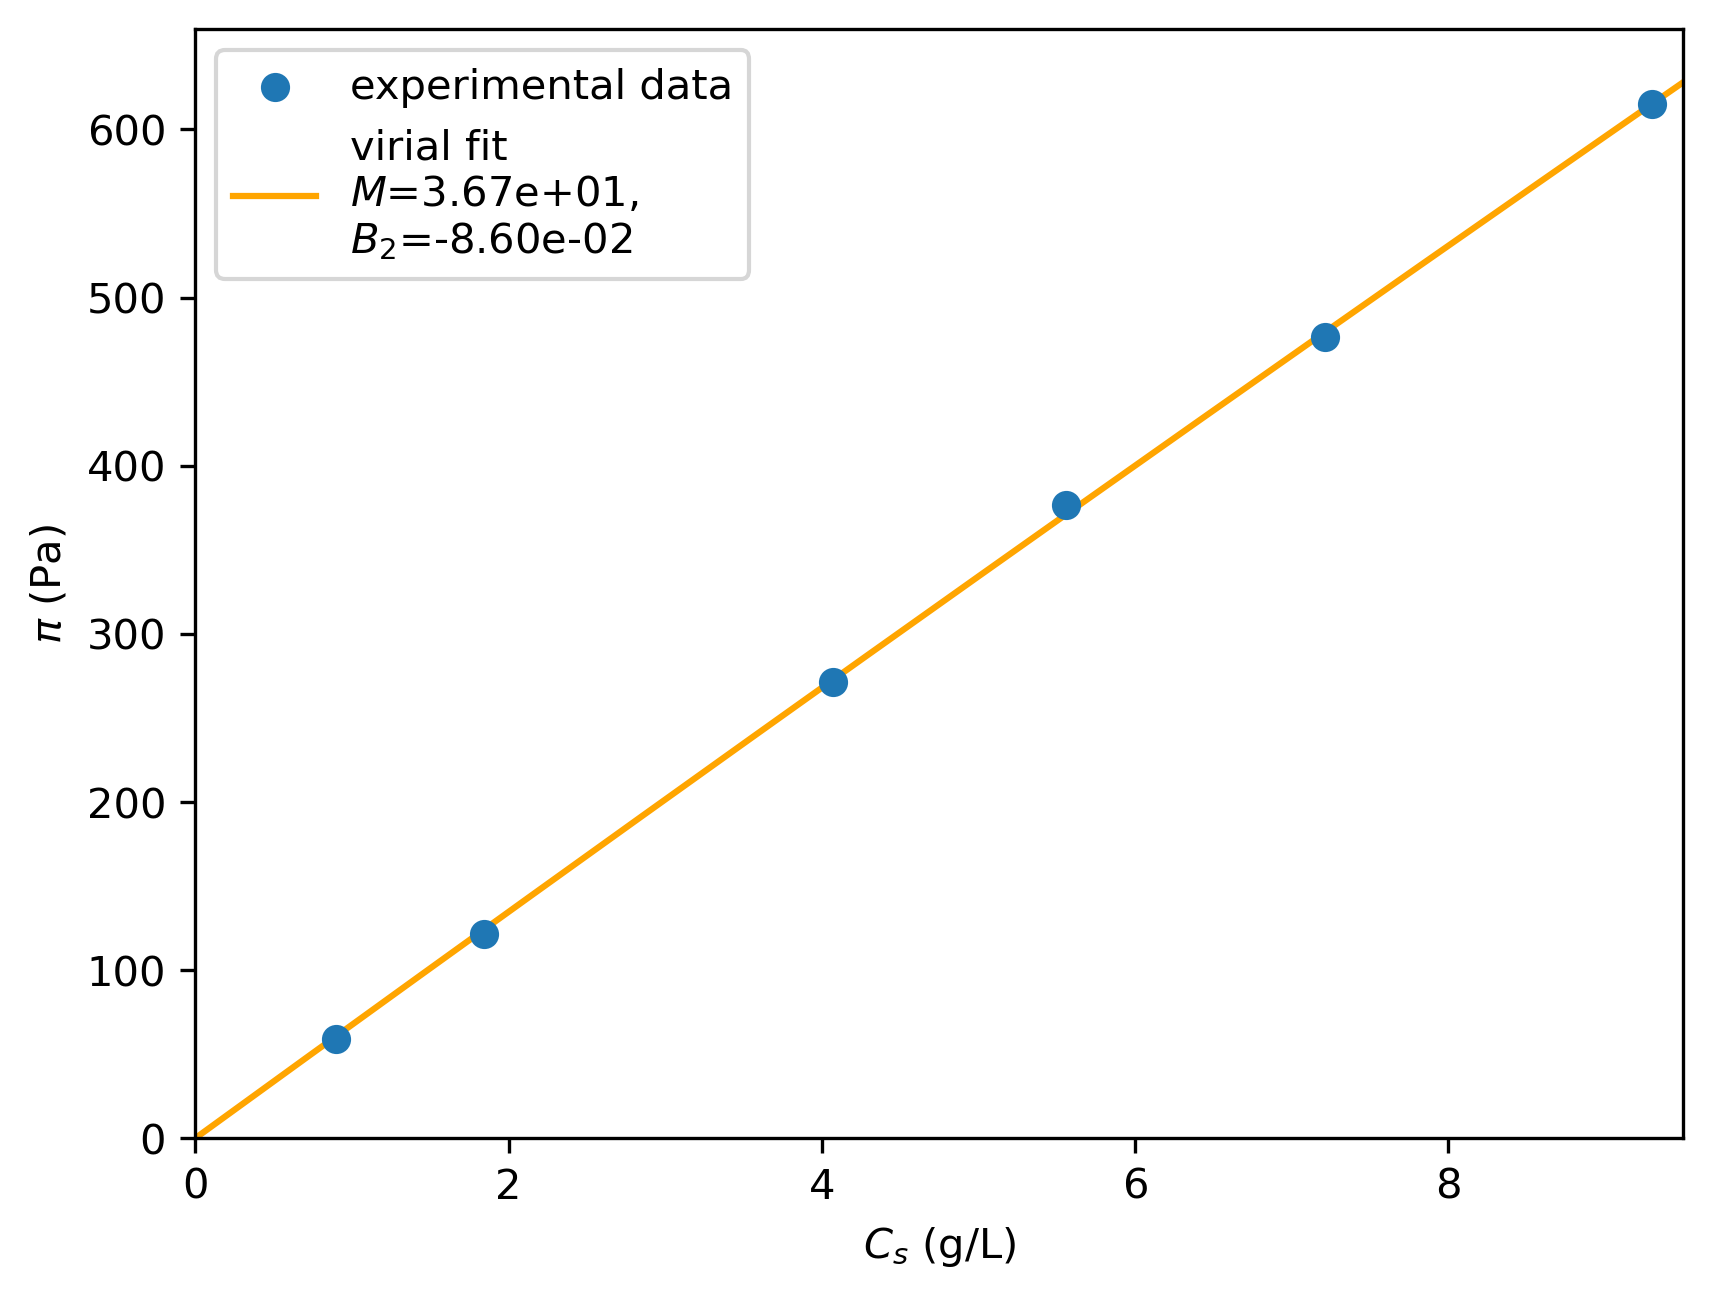

In [4]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(x, y)
ax.plot(np.linspace(0,9.5,1000), pi(np.linspace(0,9.5,1000), M=m, B2=b2), c='orange', zorder=-10)
ax.legend(['experimental data', f'virial fit\n$M$={m:.2e},\n$B_2$={b2:.2e}'])
ax.set(xlim=(0,9.5),ylim=0, xlabel='$C_s$ (g/L)', ylabel='$\pi$ (Pa)');

looks good to me. we can also try just a simple polynomial fit approach by rearranging our equation a little bit

$$
\frac{\pi}{RT} = \left(\frac{1}{M}\right) C_{s} + \left(\frac{B_2}{M^2}\right)  C_{s}^2
$$

and then we can use fitted parameters to find $M$ and $B_2$ from

$$
\pi = X_0 + X_1 C_s + X_2 C_s^2
$$

$$
M = \frac{1}{X_1} \hspace{3em} B_2 = M^2 X_2
$$

In [5]:
(x2, x1, x0) = np.polyfit(x, y/R/T, 2)
print(f'fit parameters: {np.round((x0, x1, x2),4)}')

M = 1/x1
print(f'M: {1e3*M:.1f}')

B2 = M**2 * x2
print(f'B2: {B2:.3f}')

fit parameters: [-0.0019  0.0281 -0.0001]
M: 35641.2
B2: -0.165


now visualizing this fit

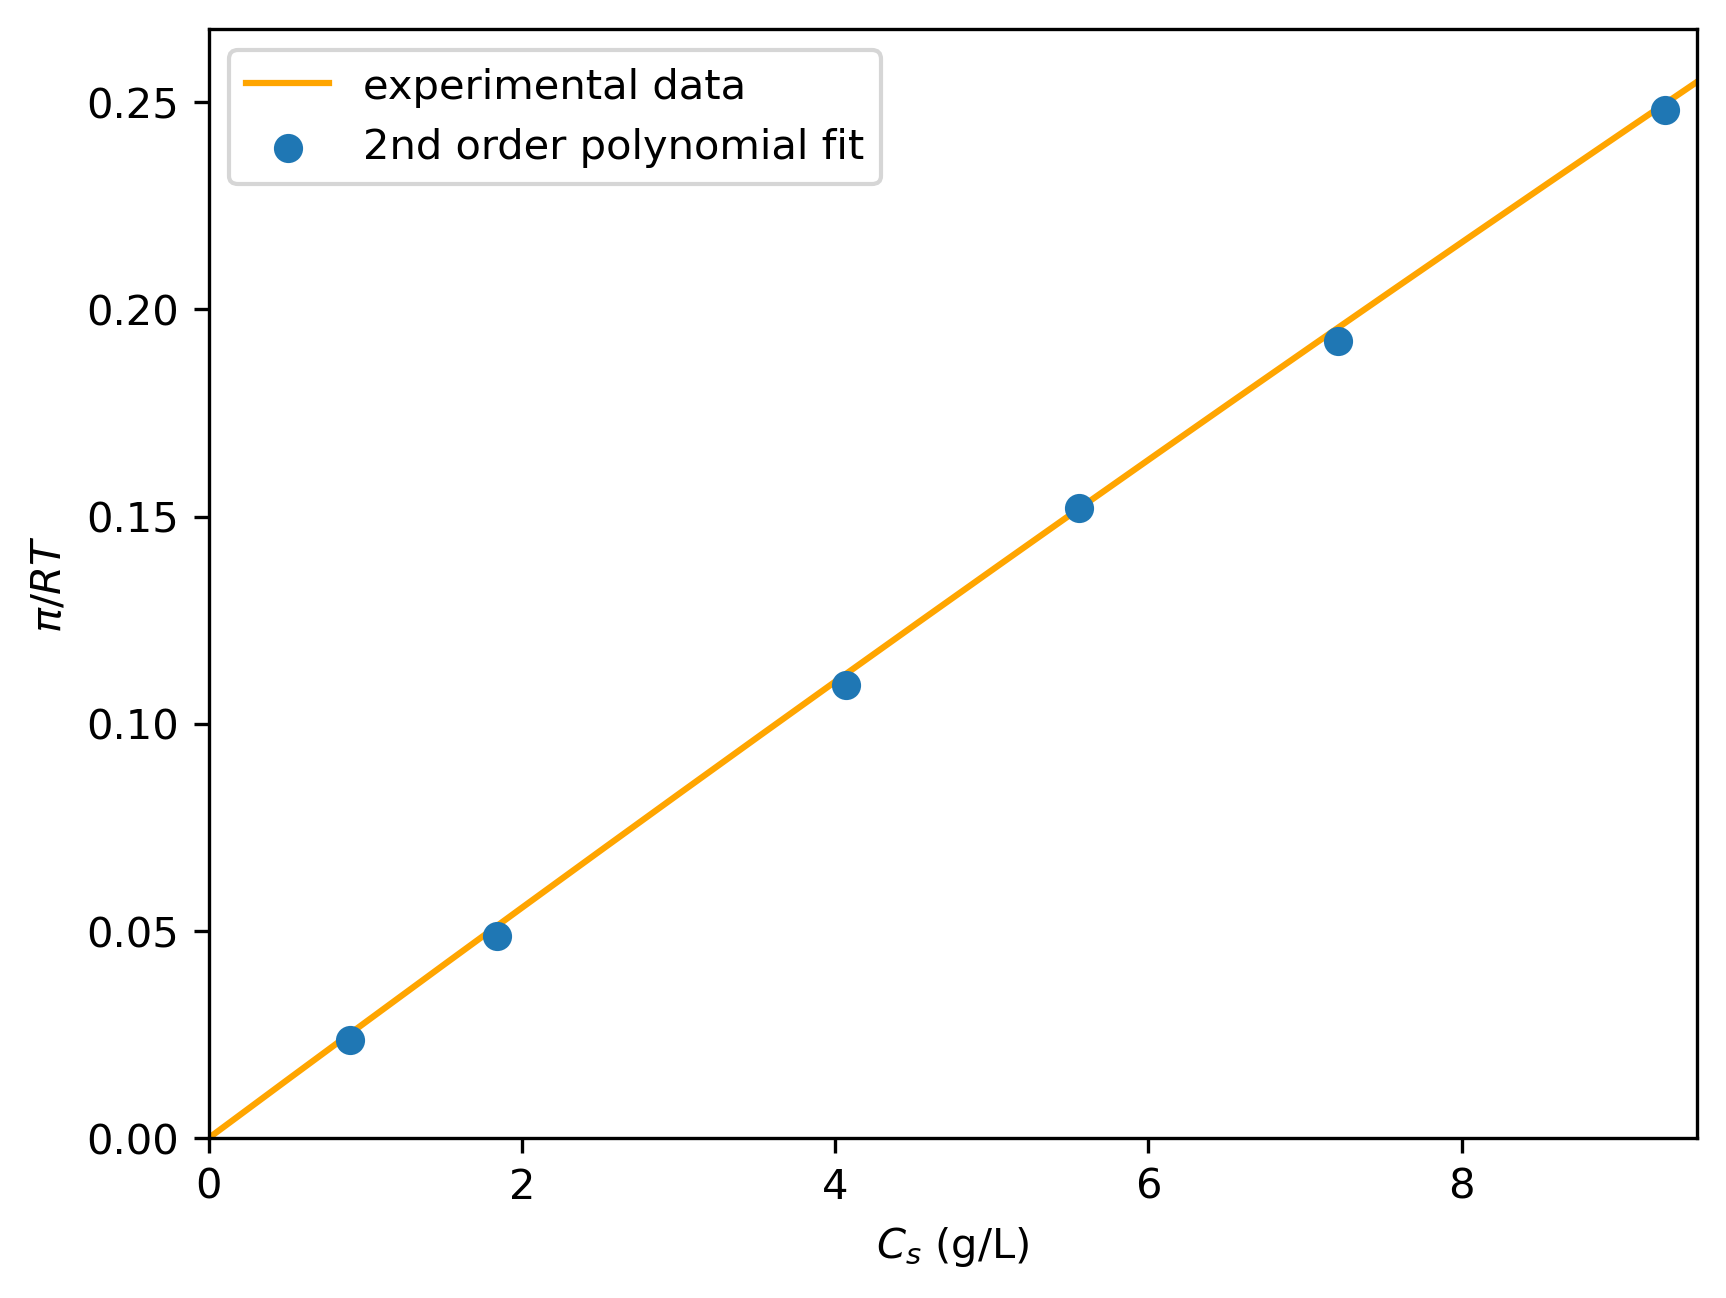

In [6]:
fig, ax = plt.subplots(dpi=300)
plt.plot(np.linspace(0,9.5,1000), x1*np.linspace(0,9.5,1000) + x2*np.linspace(0,9.5,1000)**2, c='orange',zorder=-10)
plt.scatter(x, y/R/T)
ax.legend(['experimental data', '2nd order polynomial fit'])
ax.set(xlim=(0,9.5), ylim=0, xlabel='$C_s$ (g/L)', ylabel='$\pi/RT$');

another thing we could try (even though whoever grades this will probably never even read this line) is dividing the equation by $C_s$ and doing just a linear fit!

$$
\frac{\pi}{RT C_s} = \left(\frac{1}{M}\right)  + \left(\frac{B_2}{M^2}\right)  C_{s}
$$

In [7]:
m, b = np.polyfit(x, y/R/T/x, 1)

M = 1/b
print(f'M: {1e3*M:.1f} g/mol')

B2 = M**2 * m
print(f'B2: {B2:.3f}')

M: 37697.8 g/mol
B2: 0.063


it's interesting that this method produces a positive $B_2$. let's look at what we're actually trying to fit a line to

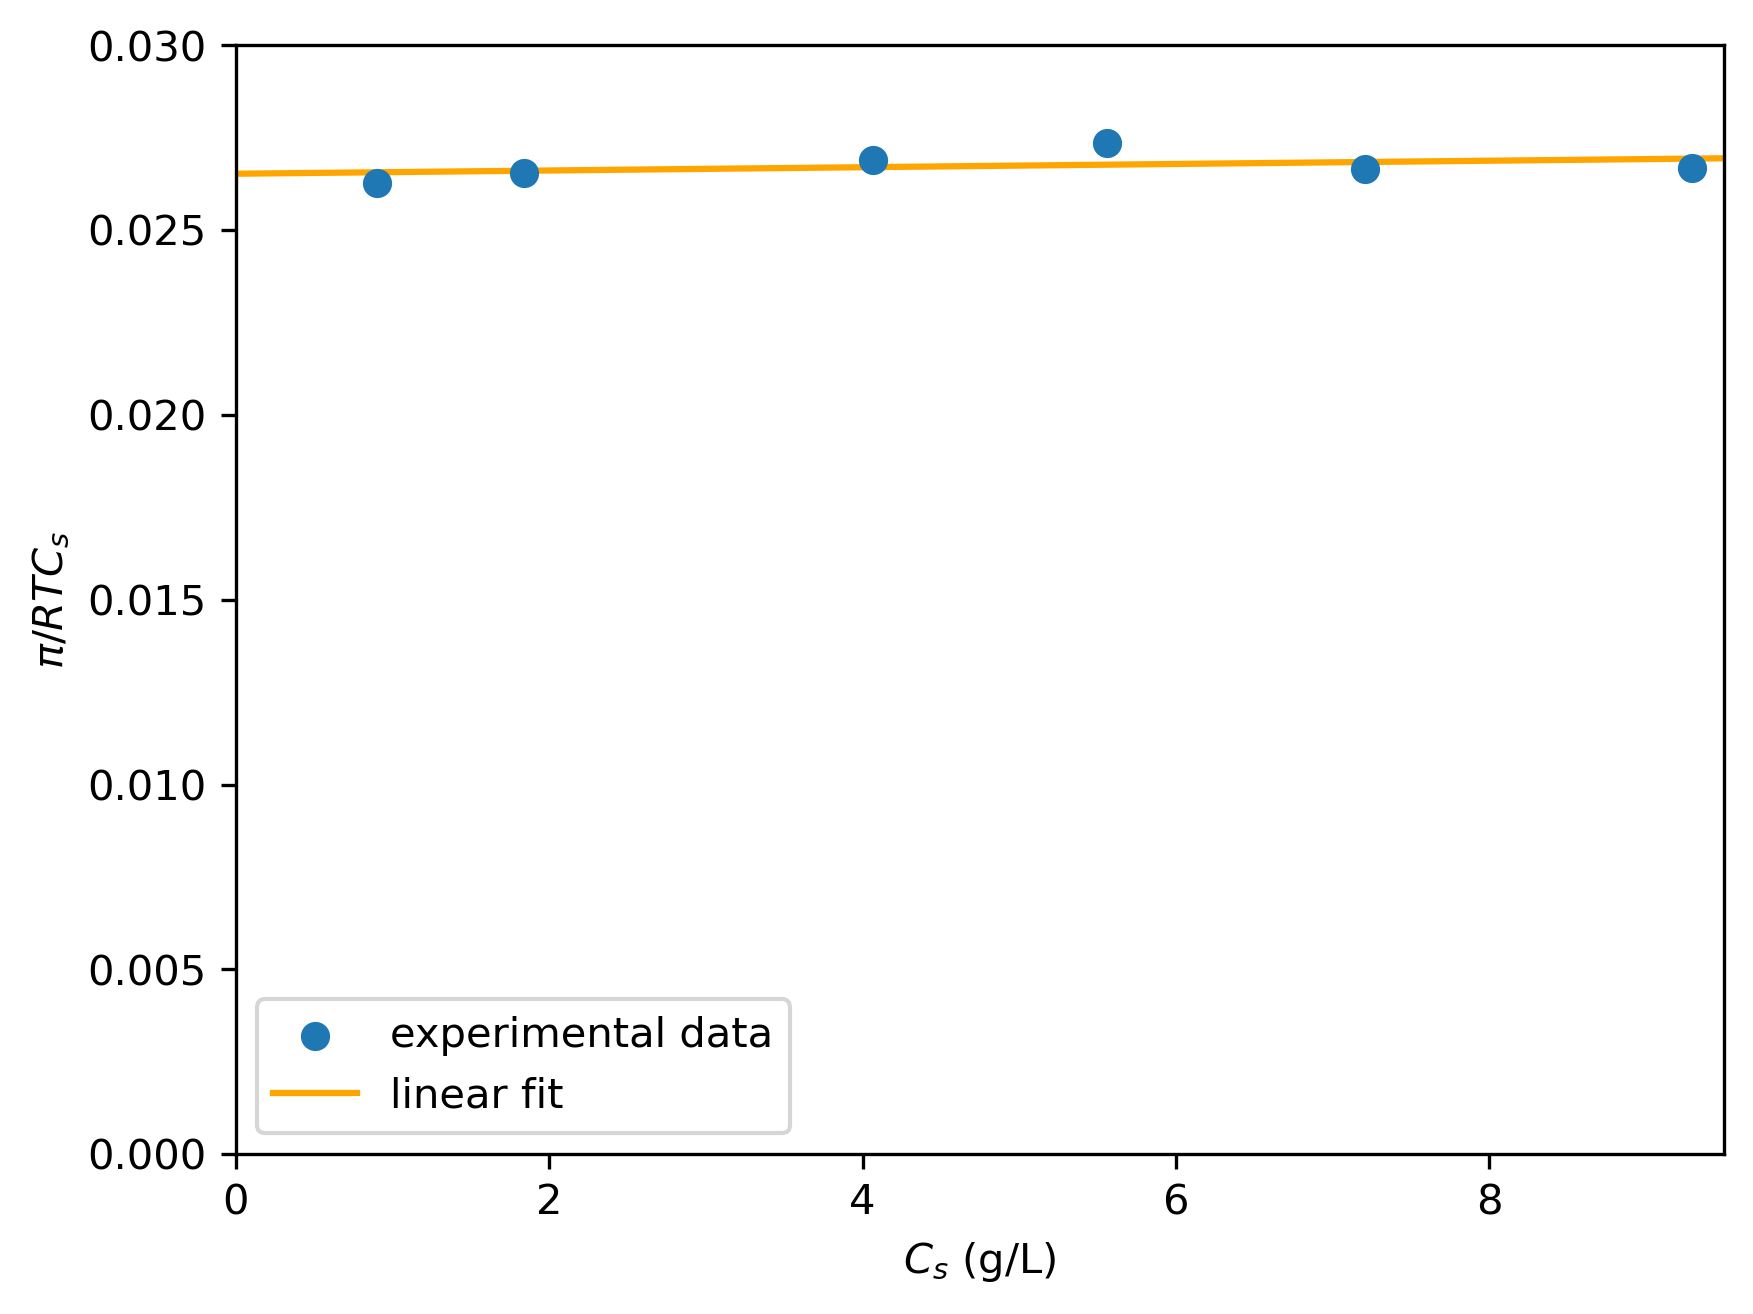

In [8]:
fig, ax = plt.subplots(dpi=300)
plt.scatter(x, y/R/T/x)
ax.plot(np.linspace(0,9.5,1000), m*np.linspace(0,9.5,1000) + b, c='orange', zorder=-10)
ax.legend(['experimental data', 'linear fit'])
ax.set(xlim=(0,9.5), ylim=(0,0.03), xlabel='$C_s$ (g/L)', ylabel='$\pi/RTC_s$');

the different approaches giving different results is an artifact of the data being real experimental data and not data that perfectly fits this model. 

In [9]:
# filler